In [ ]:
import torch as T

In [ ]:
from PIL import Image, ImageOps
import numpy as np

In [9]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT

In [10]:
%%time
env = gym_tetris.make('TetrisA-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

#a = np.zeros((10000,240, 256, 3), dtype = np.uint8)
i = 0
done = False
env.reset()
while not done:
    #if done:
        #state = env.reset()
    state , reward, done, _ = env.step(env.action_space.sample())
    #i += 1

    #env.render()
#print(state.shape)

env.close()

Wall time: 15.1 s


In [ ]:
a = np.copy(state[47:209, 95:176, :])

In [ ]:
a.shape

(162, 81, 3)

In [ ]:
mini_state = (a[..., :3] @ [0.299, 0.587, 0.114]).astype(np.uint8)

In [ ]:
b = a[..., :3] @ [0.299, 0.587, 0.114]
b[b!=0]

array([130.728,  89.939,  87.29 , ...,  94.929, 121.393, 102.407])

In [ ]:
#mini_state = np.zeros((20,10), dtype=np.int8)
idcs_y = np.arange(4,81,8)
idcs_x = np.arange(4,162,8)
mini_state = mini_state[idcs_x[:, np.newaxis],idcs_y]
mini_state[mini_state > 0] = 1
mini_state

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
np.packbits(mini_state.astype(bool))

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1,
        0, 96,  0,  0,  0,  0,  0,  0], dtype=uint8)

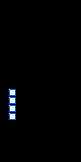

In [ ]:
im = Image.fromarray(a, 'RGB')
#im = im.convert('L')
im

In [ ]:
im = Image.fromarray(a, 'L')
#im.convert('L')
b = np.asarray(im)
b = b.astype('bool')

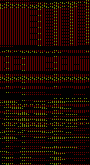

In [ ]:
im

In [ ]:
np.packbits(b)

array([255, 255, 255, ..., 255, 255,   0], dtype=uint8)

In [ ]:
info

{'board_height': 0,
 'current_piece': 'Jr',
 'next_piece': 'Zh',
 'number_of_lines': 0,
 'score': 0,
 'statistics': {'I': 0, 'J': 1, 'L': 0, 'O': 0, 'S': 0, 'T': 0, 'Z': 0}}

In [ ]:
class QNetworkCNN(nn.Module):
    def __init__(self, action_dim):
        super(QNetworkCNN, self).__init__()

        self.conv_1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=4, stride=3)
        self.conv_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc_1 = nn.Linear(8960, 512)
        self.fc_2 = nn.Linear(512, action_dim)

    def forward(self, inp):
        inp = inp.view((1, 3, 210, 160))
        x1 = F.relu(self.conv_1(inp))
        x1 = F.relu(self.conv_2(x1))
        x1 = F.relu(self.conv_3(x1))
        x1 = torch.flatten(x1, 1)
        x1 = F.leaky_relu(self.fc_1(x1))
        x1 = self.fc_2(x1)

        return x1

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


In [ ]:
class QNetworkCNN(nn.Module):
    def __init__(
        self,
        in_channel=4,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        stride=2,
        action_dim=4
        ):
      
        self.enc = Encoder(in_channel, channel, n_res_block, n_res_channel, stride)
        self.fc_1 = nn.Linear(8960, 512)
        self.fc_2 = nn.Linear(512, action_dim)
      

    def forward(self, inp):
      inp = inp.view((1, 163, 80))
      x = self.enc.forward(inp)
      x = torch.flatten(x, 1)
      x = F.relu(self.fc_1(x))
      x = T.nn.Softmax(self.fc_2(x))

      return x

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape):
        self.size_ctr = 0
        self.max_size = max_size

        self.states = np.zeros((max_size, *input_shape), dtype=np.float32) #TODO: uint8
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.float32)
        self.is_dones = np.zeros(max_size, dtype=np.float32)


    def store(self, state, action, reward, done):
        idx = self.size_ctr % self.max_size

        if not done:
          self.states[self.size_ctr] = state
          
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.is_dones[idx] = done
        self.size_ctr += 1

    def sample(self, batch_size):

        max_idx = min(self.max_size, self.size_ctr) - 1
        idcs = np.random.choice(max_idx, batch_size, replace=False)

        states = self.state[idcs]
        next_states = self.states[idcs+1]
        actions = self.actions[idcs]
        rewards = self.rewards[idcs]
        is_dones = self.is_done[idcs]

        return states, next_states, actions, rewards, is_dones
    
    def getData(self):
        return np.array(self.states[self.size_ctr], self.rewards[self.size_ctr],
                        self.actions[self.size_ctr], self.is_dones[self.size_ctr])

In [ ]:
class Agent:
    def __init__(self, batch_size, input_shape, max_buffer_size, epsilon, gamma, lr, epsilon_decay
                 , min_epsilon, n_actions, training=True):
        
        self.input_shape = input_shape
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.max_buffer_size = max_buffer_size
            
        self.target_QNetwork = QNetworkCNN(action_dim=n_actions).to(device)
        self.n_actions = n_actions
        
        self.replay_buffer = ReplayBuffer(max_buffer_size, input_shape)

        for parameter in target_QNetwork.parameters():
            parameter.requires_grad = False

        if training:
            self.lr = lr
            self.batch_size = batch_size
            
            self.predict_QNetwork = QNetworkCNN(action_dim=n_actions).to(device)
            self.target_QNetwork.load_state_dict(self.predict_QNetwork.state_dict())
            
            self.optimizer = T.optim.Adam(self.predict_QNetwork.parameters(), lr=lr)
            #self.scheduler = StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

            

    
    def chooseAction(self, state, use_epsilon=True):

      if not use_epsilon or np.random.random() > self.epsilon:
        state = torch.Tensor(state).to(device) #TODO
        with torch.no_grad():
            predictions = self.predict_QNetwork(state)
        return T.argmax(predictions) #TODO
        
      else:
        return np.random.randint(self.n_actions)
        
    def train(self, epochs):

      for _ in range(epochs):

        states, next_states, actions, rewards, is_done = self.replay_buffer.sample(batch_size)

        Q_values = self.predict_QNetwork(states)

        next_Q_values = self.predict_QNetwork(next_states)
        next_Q_state_values = self.target_QNetwork(next_states)

        Q_value = Q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        next_q_value = next_q_state_values.gather(1, T.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        expected_q_value = rewards + self.gamma * next_q_value * (1 - is_done)

        loss = T.nn.MSELoss(q_value, expected_q_value.detach()) #no gradients needed for expected values
        optim.zero_grad()
        loss.backward()
        optim.step()          #TODO: crossEntropy ?

        T.save()

    def preFillReplayBuffer(self, n_steps):

      for _ in range(n_steps):
        action = chooseAction(env, state, eps)
        state, reward, done, _ = env.step(action)

        self.replay_buffer.store(state, action, reward, done)

#TODO: put replayBuffer in VRAM

    def previewAgent(self, weights_file=None):
      if weights_file:
        #T.load
        pass

      total_reward = 0
      state = env.reset()
      done = False
      while not done:
          state = T.Tensor(state).to(device)
          with torch.no_grad():
              values = self.chooseAction(state)
      
          state, reward, done, _ = env.step(action)
          total_reward += reward
          env.render()
          
    
    return total_reward

    #def loadWeights(self, file_path):
       # self.targetQNetwork
                    


In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT
from AgentDoubleQ import Agent

class GameCollector:
    
    def __init__(self, weights_file):
        self.agent = Agent(training=False, max_buffer_size=10000)
        self.weights_file = weights_file
        
        self.tmp_states = np.zeros((4, *self.input_shape), dtype=np.uint8) 
        self.tmp_rewards = np.zeros(4, dtype=np.uint8)
        self.tmp_actions = np.zeros(4, dtype=np.uint8)
        self.tmp_is_dones = np.zeros(4, dtype=np.uint8)
        
    def preProcessFrame(self, frame):
        frame = np.copy(frame[47:209, 95:176, :])
        frame = (frame[..., :3] @ [0.299, 0.587, 0.114]).astype(np.uint8)
        idcs_y = np.arange(4,81,8)
        idcs_x = np.arange(4,162,8)
        frame = frame[idcs_x[:, np.newaxis],idcs_y]
        
        return frame
    
    def play(self, epochs, steps_limit):
        env = gym_tetris.make('TetrisA-v0')
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        
        for _ in range(epochs):
            env.reset()
            done = False
            steps_ctr = 0
            
            while not done:
                idx = steps_ctr % 4
                action = self.chooseAction()
                state, reward, done, _ = env.step(action)
                
                tmp_states[idx] =  self.preProcessFrame(state)
                tmp_rewards[idx] = reward
                tmp_actions[idx] = action
                tmp_is_dones[idx] = done
                
                
                if step_ctr and idx == 0:
                    self.agent.replay_buffer.store(tmp_states, tmp_actions, tmp_rewards, tmp_is_dones)
                
                steps_ctr += 1
                   
        env.close()
    
    def run(self):
    
        self.target_QNetwork.load_state_dict(self.weights_file)
        self.play(10)
        np.save('test', self.agent.replay_buffer.getData())
        